<a href="https://colab.research.google.com/github/as791/Adversarial-Example-Attack-and-Defense/blob/master/Adversarial_Example_(Attack_and_defense).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

In [4]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 50000 Validation data: 10000 Test data:  10000


In [5]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

##Attack

In [6]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [7]:
model = Net().to(device)

In [8]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [9]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [10]:
epochs = 20

In [11]:
loss,val_loss=fit(model,device,train_loader,val_loader,epochs)

Fitting the model...


/raid/infolab/suma/anaconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.2832378301733913 Val_Loss: 0.12834794865343532
Epoch: 2 Loss: 0.10521468927360098 Val_Loss: 0.11200412489861442
Epoch: 3 Loss: 0.08346013580085967 Val_Loss: 0.10077222260391207
Epoch: 4 Loss: 0.07401052369855211 Val_Loss: 0.10596037700096705
Epoch: 5 Loss: 0.06902917743977208 Val_Loss: 0.09849674311714354
Epoch: 6 Loss: 0.0675102619607845 Val_Loss: 0.08286533014453341
Epoch: 7 Loss: 0.06300733063803683 Val_Loss: 0.08035209000377182
Epoch: 8 Loss: 0.06293300900802526 Val_Loss: 0.0896406675571012
Epoch: 9 Loss: 0.060040095550369335 Val_Loss: 0.09404897159660529
Epoch: 10 Loss: 0.05963963540023416 Val_Loss: 0.0851999572362398
Epoch: 11 Loss: 0.0622691865594401 Val_Loss: 0.08805481142940405
Epoch: 12 Loss: 0.04546901311275813 Val_Loss: 0.0820616208482827
Epoch: 13 Loss: 0.04504101235192659 Val_Loss: 0.07837036539236793
Epoch: 14 Loss: 0.04166021983841841 Val_Loss: 0.07855656871991817
Epoch: 15 Loss: 0.04176142997044128 Val_Loss: 0.07725201115083358
Epoch: 16 Loss: 0.040740

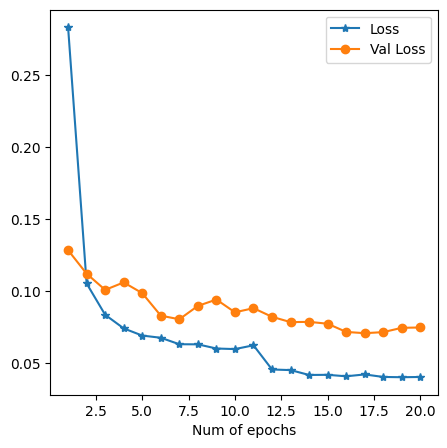

In [14]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,epochs+1), loss, "*-",label="Loss")
plt.plot(np.arange(1,epochs+1), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [18]:
## saving the model
torch.save(model.state_dict(),"mnist_model.pth")

In [15]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

In [16]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1] 
      if init_pred.item() != target.item():
          continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
        
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples


Epsilon: 0	Test Accuracy = 9751 / 10000 = 0.9751
Epsilon: 0.007	Test Accuracy = 9721 / 10000 = 0.9721
Epsilon: 0.01	Test Accuracy = 9675 / 10000 = 0.9675
Epsilon: 0.02	Test Accuracy = 9669 / 10000 = 0.9669
Epsilon: 0.03	Test Accuracy = 9605 / 10000 = 0.9605
Epsilon: 0.05	Test Accuracy = 9402 / 10000 = 0.9402
Epsilon: 0.1	Test Accuracy = 8532 / 10000 = 0.8532
Epsilon: 0.2	Test Accuracy = 4904 / 10000 = 0.4904
Epsilon: 0.3	Test Accuracy = 2062 / 10000 = 0.2062


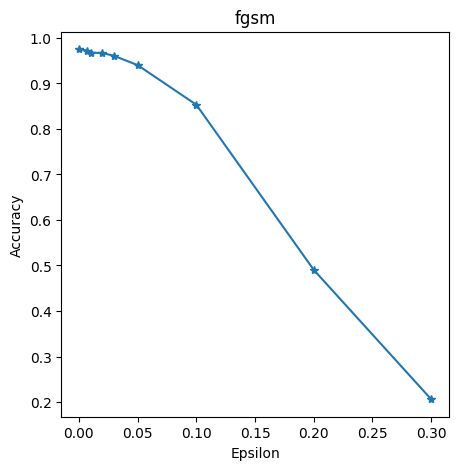

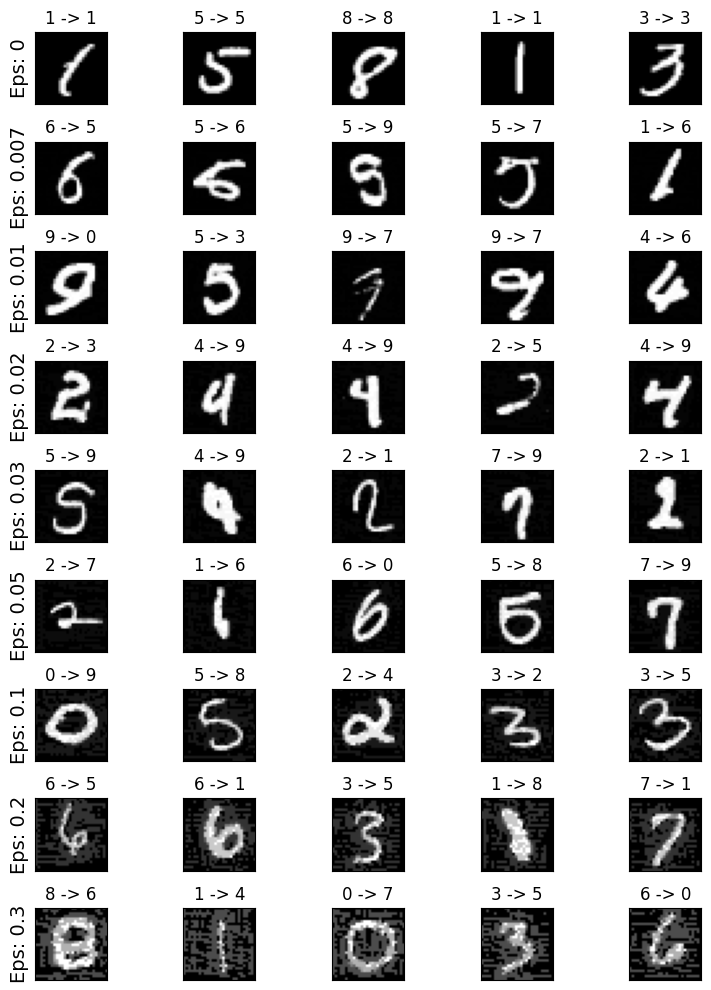

/raid/infolab/suma/anaconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epsilon: 0	Test Accuracy = 9756 / 10000 = 0.9756
Epsilon: 0.007	Test Accuracy = 9740 / 10000 = 0.974
Epsilon: 0.01	Test Accuracy = 9716 / 10000 = 0.9716
Epsilon: 0.02	Test Accuracy = 9682 / 10000 = 0.9682
Epsilon: 0.03	Test Accuracy = 9632 / 10000 = 0.9632
Epsilon: 0.05	Test Accuracy = 9478 / 10000 = 0.9478
Epsilon: 0.1	Test Accuracy = 8798 / 10000 = 0.8798
Epsilon: 0.2	Test Accuracy = 5707 / 10000 = 0.5707
Epsilon: 0.3	Test Accuracy = 2642 / 10000 = 0.2642


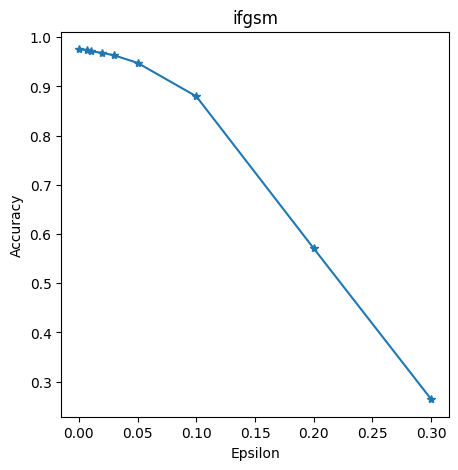

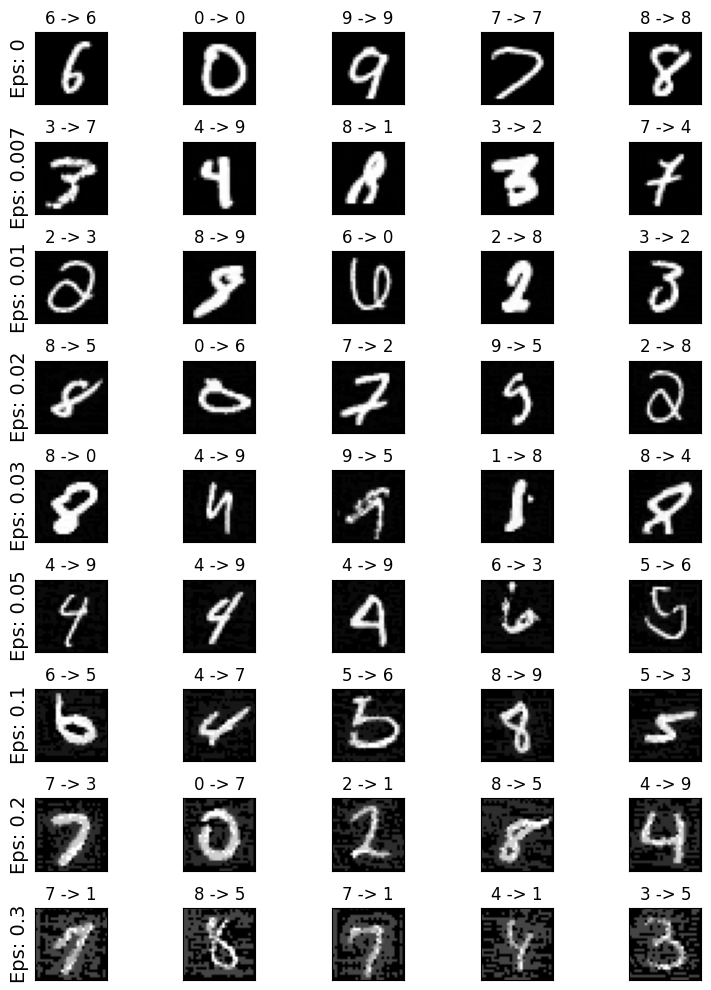

/raid/infolab/suma/anaconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epsilon: 0	Test Accuracy = 9745 / 10000 = 0.9745
Epsilon: 0.007	Test Accuracy = 9711 / 10000 = 0.9711
Epsilon: 0.01	Test Accuracy = 9722 / 10000 = 0.9722
Epsilon: 0.02	Test Accuracy = 9692 / 10000 = 0.9692
Epsilon: 0.03	Test Accuracy = 9613 / 10000 = 0.9613
Epsilon: 0.05	Test Accuracy = 9497 / 10000 = 0.9497
Epsilon: 0.1	Test Accuracy = 8816 / 10000 = 0.8816
Epsilon: 0.2	Test Accuracy = 5702 / 10000 = 0.5702
Epsilon: 0.3	Test Accuracy = 2642 / 10000 = 0.2642


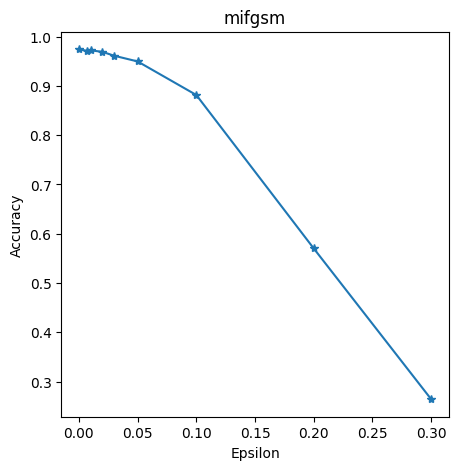

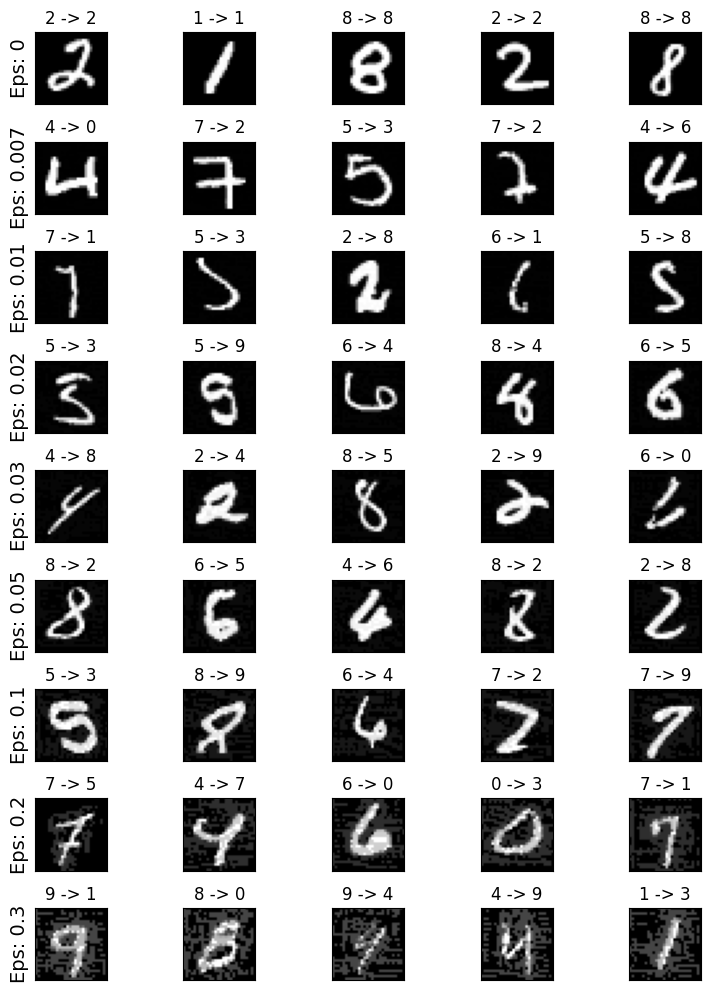

In [17]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
      acc, ex = test(model, device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()